In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [3]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
%%R
data <- read.csv('Price_district.csv')

In [52]:
%%R
# Create a new column to categorize the region of the district
data$Region <- factor(ifelse(data$District %in% c("Central and Western District", "Wan Chai District", "Eastern District", "Southern District"),
                             "Hong Kong Island",
                      ifelse(data$District %in% c("Yau Tsim Mong District", "Sham Shui Po District", "Kowloon City District", "Wong Tai Sin District", "Kwun Tong District"),
                                    "Kowloon",
                                    "New Territories")))

In [53]:
%%R
head(data)

               District Price  Region
1 Kowloon City District   $36 Kowloon
2 Kowloon City District   $33 Kowloon
3 Kowloon City District   $37 Kowloon
4 Kowloon City District   $30 Kowloon
5 Kowloon City District   $38 Kowloon
6    Kwun Tong District   $43 Kowloon


In [54]:
%%R

# Make sure price is numeric without deleting the data and remove the $ sign
data$Price <- as.numeric(gsub("\\$", "", data$Price))
data$Price <- as.numeric(gsub(",", "", data$Price))


In [56]:
%%R

#Calculate the median price of each region
median_price <- aggregate(Price ~ Region, data, median)
median_price

            Region Price
1 Hong Kong Island    35
2          Kowloon    32
3  New Territories    32


In [57]:
%%R

#Calculate the median price of each district
median_price_district <- aggregate(Price ~ District, data, median)
median_price_district <- median_price_district[order(median_price_district$Price, decreasing=TRUE),]
median_price_district

                       District Price
3              Islands District  38.0
1  Central and Western District  36.0
15            Wan Chai District  36.0
13           Tsuen Wan District  35.0
18           Yuen Long District  35.0
17       Yau Tsim Mong District  34.0
5           Kwai Tsing District  33.0
6            Kwun Tong District  33.0
8             Sai Kung District  33.0
14            Tuen Mun District  33.0
16        Wong Tai Sin District  33.0
2              Eastern District  32.0
4         Kowloon City District  32.0
10        Sham Shui Po District  32.0
7                North District  30.0
9              Sha Tin District  30.0
11            Southern District  29.5
12              Tai Po District  28.5


In [64]:
%%R

library(dplyr)

medians <- data %>%
  group_by(Region) %>%
  summarize(MedianPrice = median(Price, na.rm = TRUE))

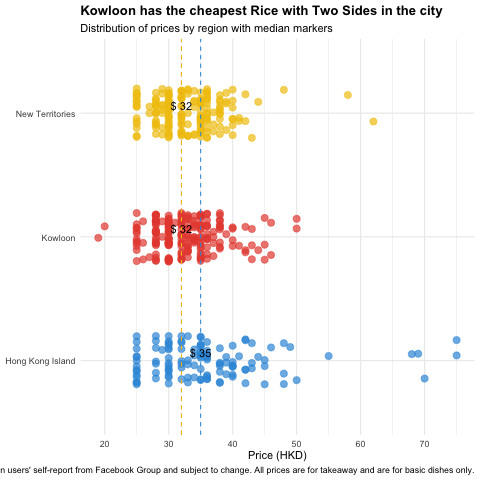

In [118]:
%%R

library(ggplot2)
library(dplyr)

# Calculate median prices for each region
medians <- data %>%
  group_by(Region) %>%
  summarize(MedianPrice = median(Price))

# Create the plot with simplified x-axis and median price markers
plot <- ggplot(data, aes(x = Price, y = Region)) +
  geom_point(aes(color = Region), size = 3, position = position_jitter(width = 0, height = 0.2), alpha = 0.7) +
  scale_x_continuous(breaks = c(20,30,40,50,60,70,80)) +  # Simplify x-axis
  scale_color_manual(values = c("Hong Kong Island" = "#3498db", "Kowloon" = "#e74c3c", "New Territories" = "#f1c40f")) +
  geom_vline(data = medians, aes(xintercept = MedianPrice, color = Region), linetype = "dashed") +
  geom_text(data = medians, aes(x = MedianPrice, y = Region, label = paste("$", MedianPrice)), vjust = -0.5, color = "black") +
  theme_minimal() +
  theme(axis.title.y = element_blank(), axis.text.y = element_text(angle = 0),legend.position = "none", plot.title = element_text(face = "bold")) +
  labs(title = "Kowloon has the cheapest Rice with Two Sides in the city", # Add your title here
       subtitle = "Distribution of prices by region with median markers",  # Add your subtitle here
       x = "Price (HKD)",
       color = "Region",
       caption = "Note: Prices are based on users' self-report from Facebook Group and subject to change. All prices are for takeaway and are for basic dishes only.")  # Add your note here as a caption

# Display the plot
print(plot)

# Save the plot as a .png file
ggsave("landscape_plot_region.png", plot, width = 12, height = 6, dpi = 300)

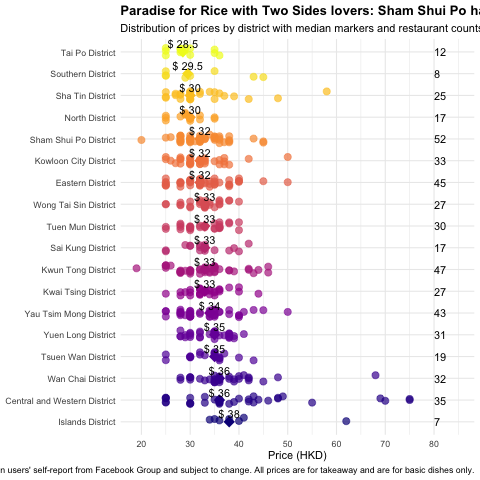

In [116]:
%%R

library(ggplot2)
library(dplyr)
library(viridis)

# Calculate median prices for each district and sort the districts by median price from highest to lowest
medians <- data %>%
  group_by(District) %>%
  summarize(MedianPrice = median(Price, na.rm = TRUE)) %>%
  arrange(desc(MedianPrice))

# Calculate the count of restaurants for each district
restaurant_counts <- data %>%
  group_by(District) %>%
  summarize(Count = n())

# Ensure the District factor in the data data frame is ordered based on the sorted medians data frame
data$District <- factor(data$District, levels = medians$District)

# Find the maximum price value for positioning text labels
max_price <- max(data$Price, na.rm = TRUE)

# Create the plot with simplified x-axis, median price markers for each district and sort the districts by median price from highest to lowest
plot <- ggplot(data, aes(x = Price, y = District)) +
  geom_point(aes(color = District), position = position_jitter(width = 0, height = 0.2), size = 3, alpha = 0.7) +
  scale_x_continuous(limits = c(NA, max_price + 10), breaks = c(20, 30, 40, 50, 60, 70, 80)) +  # Extend x-axis to accommodate restaurant counts
  scale_color_viridis_d(option = "C") +
  geom_point(data = medians, aes(x = MedianPrice, y = District, color = District), size = 5, shape = 18) +  # Median price markers
  geom_text(data = medians, aes(x = MedianPrice, y = District, label = paste("$",MedianPrice)), vjust = -0.5, color = "black") +
  geom_text(data = restaurant_counts, aes(x = max_price + 5, y = District, label = paste(Count)), hjust = 0, color = "black") +  # Restaurant counts
  theme_minimal() +
  theme(axis.title.y = element_blank(), axis.text.y = element_text(angle = 0), legend.position = "none", plot.title = element_text(face = "bold")) +
  labs(title = "Paradise for Rice with Two Sides lovers: Sham Shui Po has the variety and the best prices in the city", 
       subtitle = "Distribution of prices by district with median markers and restaurant counts",
       x = "Price (HKD)",
       caption = "Note: Prices are based on users' self-report from Facebook Group and subject to change. All prices are for takeaway and are for basic dishes only.")

# Display the plot
print(plot)

# Save the plot as a .png file
ggsave("landscape_plot_district.png", plot, width = 12, height = 6, dpi = 300)

In [34]:
%%R

library(ggplot2)
library(readr)
library(dplyr)  # Ensure dplyr is loaded

# Load the CSV file and suppress the column specification message
df <- read_csv('Review.csv', show_col_types = FALSE)

# Clean the data: Remove rows with non-numeric review scores or where the review score is 0 or 5
df <- df %>%
  filter(!is.na(Score), Score != 0, Score != 5)

# Calculate the median
median_score <- median(df$Score, na.rm = TRUE)

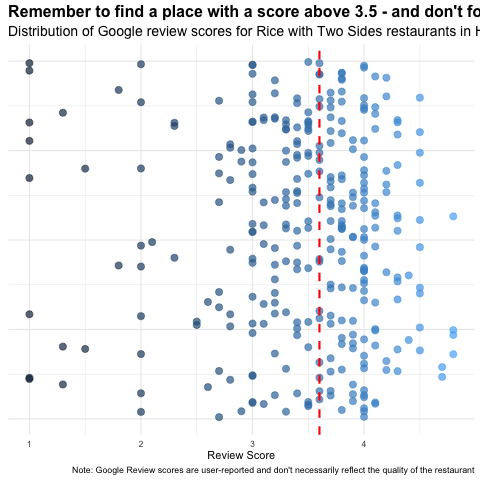

In [40]:
%%R
plot <- ggplot(df, aes(x = Score, y = 0)) +  # Set y to a constant (0) for a one-dimensional jitter plot
  geom_point(aes(color = Score), position = position_jitter(width = 0, height = 0.1), size = 3, alpha = 0.7) +
  geom_vline(xintercept = median(df$Score, na.rm = TRUE), color = 'red', linetype = 'dashed', size = 1) +
  labs(title = "Remember to find a place with a score above 3.5 - and don't forget to leave your review!", 
       subtitle = "Distribution of Google review scores for Rice with Two Sides restaurants in Hong Kong",
       x = "Review Score",
       caption = "Note: Google Review scores are user-reported and don't necessarily reflect the quality of the restaurant") +
  theme_minimal() +
  theme(legend.position = "none",
        plot.title = element_text(size = 16, face = "bold"),
        plot.subtitle = element_text(size = 14),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank())

print(plot)

# Save the plot as a .png file
ggsave("landscape_plot_review.png", plot, width = 12, height = 6, dpi = 300)

In [37]:
%%R

library(readr)
library(dplyr)

# Load the CSV file
df <- read_csv('Review.csv', show_col_types = FALSE)

# Clean the data: Remove rows with non-numeric scores or where the score is 0 or 5
df <- df %>%
  filter(!is.na(Score), Score != 0, Score != 5)

# Print restaurants with top 10 highest review scores
top_10 <- df %>%
  arrange(desc(Score)) %>%
  head(10)
top_10


# A tibble: 10 × 3
   Name                      Address             Score
   <chr>                     <chr>               <dbl>
 1 張和隆飯店                九龍城賈炳達道65號    4.8
 2 人人有飯開                旺角旺角道18-20A號    4.8
 3 美樂小食                  金鐘夏慤道18號        4.8
 4 Thai Kitchen by Chanatcha 鰂魚涌海光街 7-9 號   4.8
 5 三多美食                  北帝街27號            4.7
 6 三多美食                  汝州街232號           4.7
 7 素食軒                    九龍九龍灣展貿徑1號   4.5
 8 千鳥美食                  上環東來里2號         4.5
 9 岱民大埔店                大埔安埔路12號        4.5
10 住家菜                    天水圍天湖路1號       4.5
